# Introduction

This notebook contains a number of examples to help you get started with Spark Streaming and GraphX, for your second lab assignment. This contents of this notebook is taken from Apache Spark's [Spark Streaming Programming Guide](https://spark.apache.org/docs/2.4.3/streaming-programming-guide.html) and [GraphX Programming Guide](https://spark.apache.org/docs/2.4.3/graphx-programming-guide.html). Note that in this tutorial we do not cover Structured Streaming and GraphFrames - but we encourage you to check the latest docs to learn more about these APIs.

# Spark Streaming

Spark Streaming is an extension of the core Spark API that enables scalable, high-throughput, fault-tolerant stream processing of live data streams. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets, and can be processed using complex algorithms expressed with high-level functions like map, reduce, join and window. Finally, processed data can be pushed out to filesystems, databases, and live dashboards. In fact, you can apply Spark’s machine learning and graph processing algorithms on data streams.

Internally, it works as follows. Spark Streaming receives live input data streams and divides the data into batches, which are then processed by the Spark engine to generate the final stream of results in batches.

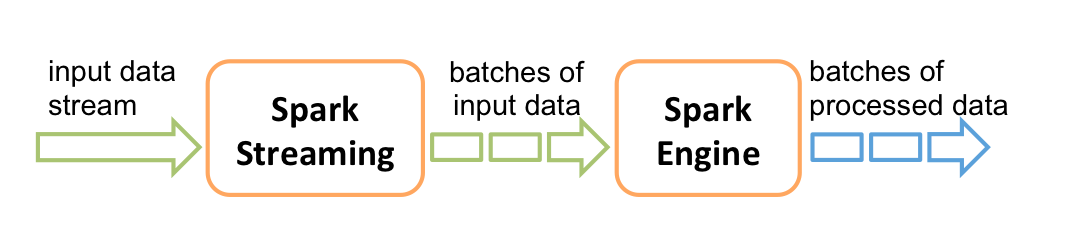


Spark Streaming provides a high-level abstraction called discretized stream or **DStream**, which represents a continuous stream of data. DStreams can be created either from input data streams from sources such as Kafka, Flume, and Kinesis, or by applying high-level operations on other DStreams. Internally, a DStream is represented as a sequence of RDDs.

## Word Count (but works with a stream)

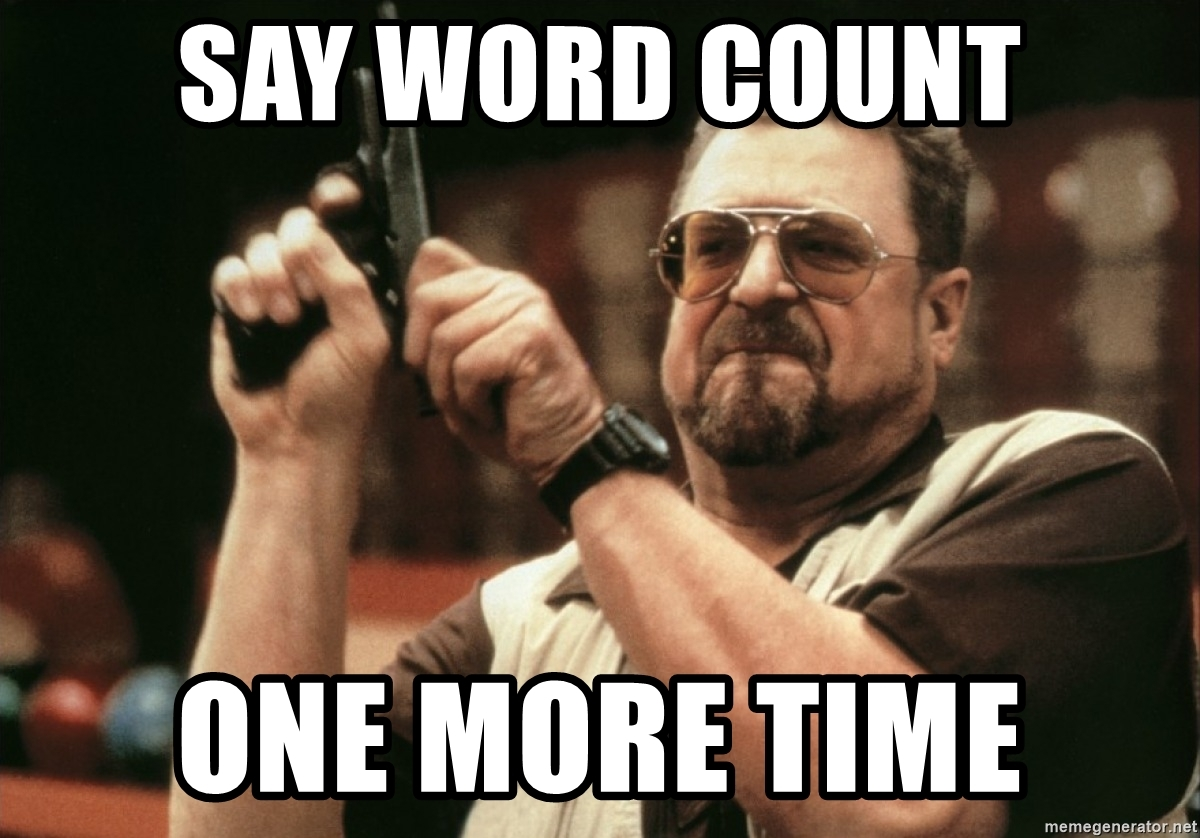


Let’s take a quick look at what a simple Spark Streaming program looks like. Let’s say we want to count the number of words in text data received from a data server listening on a TCP socket. All you need to do is as follows:

First, we import the names of the Spark Streaming classes and some implicit conversions from StreamingContext into our environment in order to add useful methods to other classes we need (like DStream). StreamingContext is the main entry point for all streaming functionality. We create a local StreamingContext with two execution threads, and a batch interval of 5 seconds.

In [ ]:
import org.apache.spark._
import org.apache.spark.streaming._
import org.apache.spark.streaming.StreamingContext._

// Create a local StreamingContext with two working thread and batch interval of 1 second.
// The master requires 2 cores to prevent a starvation scenario.

val conf = new SparkConf().setMaster("local[2]").setAppName("NetworkWordCount")
val ssc = new StreamingContext(conf, Seconds(5))

Using this context, we can create a DStream that represents streaming data from a TCP source, specified as hostname (e.g., `localhost`) and port (e.g., `9999`).

In [ ]:
// Create a DStream that will connect to hostname:port, like localhost:9999
val lines = ssc.socketTextStream("localhost", 9999)

This `lines` DStream represents the stream of data that will be received from the data server. Each record in this DStream is a line of text. Next, we want to split the lines by space characters into words.

In [ ]:
// Split each line into words
val words = lines.flatMap(_.split(" "))

`flatMap` is a one-to-many DStream operation that creates a new DStream by generating multiple new records from each record in the source DStream. In this case, each line will be split into multiple words and the stream of words is represented as the `words` DStream. Next, we want to count these words.

In [ ]:
import org.apache.spark.streaming.StreamingContext._ // not necessary since Spark 1.3
// Count each word in each batch
val pairs = words.map(word => (word, 1))
val wordCounts = pairs.reduceByKey(_ + _)

// Print the first ten elements of each RDD generated in this DStream to the console
wordCounts.print()

The `words` DStream is further mapped (one-to-one transformation) to a DStream of `(word, 1)` pairs, which is then reduced to get the frequency of words in each batch of data. Finally, `wordCounts.print()` will print a few of the counts generated every second.

Note that when these lines are executed, Spark Streaming only sets up the computation it will perform when it is started, and no real processing has started yet. To start the processing after all the transformations have been setup, we finally call:

In [ ]:
ssc.start()             // Start the computation
ssc.awaitTermination()  // Wait for the computation to terminate

Now, as the program is running, open a terminal session on your VM and execute `nc -lk 9999`, to run *Netcat*. Then, start typing words in the same terminal session, and observe the output of the above cell.

## Steps for Writing a Spark Streaming Program
That was it!

You can think of the following steps when you want to write your own Spark Streaming programs:

1. Initialize a `StreamingContext`.
1. Define the input sources by creating input DStreams. 
1. Define the streaming computations by applying transformation and output operations to DStreams.
1. Start receiving data and processing it using `streamingContext.start()`.
1. Wait for the processing to be stopped (manually or due to any error) using `streamingContext.awaitTermination()`.
1. The processing can be manually stopped using `streamingContext.stop()`.

Now let's see an example about GraphX.

# GraphX

In this example we'll go over basic graph analysis using the GraphX API.

Graph processing is an important aspect of analysis that applies to a lot of use cases. Fundamentally graph theory and processing are about defining relationships between different nodes and edges. Nodes or vertices are the units while edges are the relationships that are defined between those. This works great for social network analysis and running algorithms like [PageRank](https://en.wikipedia.org/wiki/PageRank) to better understand and weigh relationships.

Some business use cases could be to look at central people in social networks (who is most popular in a group of friends), importance of papers in bibliographic networks (which papers are most referenced), and of course ranking web pages.

To get started you first need to import Spark and GraphX into your project, as follows:

In [ ]:
import org.apache.spark._
import org.apache.spark.graphx._
// To make some of the examples work we will also need RDD
import org.apache.spark.rdd.RDD

## The Property Graph

The **property graph** is a **directed multigraph** with user defined objects attached to each vertex and edge. A directed multigraph is a directed graph with potentially multiple parallel edges sharing the same source and destination vertex. The ability to support parallel edges simplifies modeling scenarios where there can be multiple relationships (e.g., co-worker and friend) between the same vertices. Each vertex is keyed by a **unique** 64-bit long identifier (`VertexId`). Similarly, edges have corresponding source and destination vertex identifiers.

The property graph is parameterized over the vertex (`VD`) and edge (`ED`) types. These are the types of the objects associated with each vertex and edge respectively. GraphX optimizes the representation of vertex and edge types when they are **primitive data types** (e.g., int, double, etc…) reducing the in memory footprint by storing them in specialized arrays.

In some cases it may be desirable to have vertices with different property types in the same graph. This can be accomplished through **inheritance**. For example to model users and products as a bipartite graph we might do the following:

In [ ]:
class VertexProperty()
case class UserProperty(val name: String) extends VertexProperty
case class ProductProperty(val name: String, val price: Double) extends VertexProperty
// The graph might then have the type:
val graph: Graph[VertexProperty, String] = null

Like RDDs, property graphs are immutable, distributed, and fault-tolerant. Changes to the values or structure of the graph are accomplished by producing a new graph with the desired changes. The graph is partitioned across the executors using a range of vertex partitioning heuristics. As with RDDs, each partition of the graph can be recreated on a different machine in the event of a failure.

Logically, the property graph corresponds to a pair of typed collections (RDDs) encoding the properties for each vertex and edge. As a consequence, the graph class contains members to access the vertices and edges of the graph:

In [ ]:
class Graph[VD, ED] {
  val vertices: VertexRDD[VD]
  val edges: EdgeRDD[ED]
}

The classes `VertexRDD[VD]` and `EdgeRDD[ED]` extend and are optimized versions of R`DD[(VertexId, VD)]` and `RDD[Edge[ED]]` respectively. Both `VertexRDD[VD]` and `EdgeRDD[ED]` provide additional functionality built around graph computation and leverage internal optimizations.

## Example Property Graph

Suppose we want to construct a property graph consisting of the various collaborators on the GraphX project. The vertex property might contain the username and occupation. We could annotate edges with a string describing the relationships between collaborators:

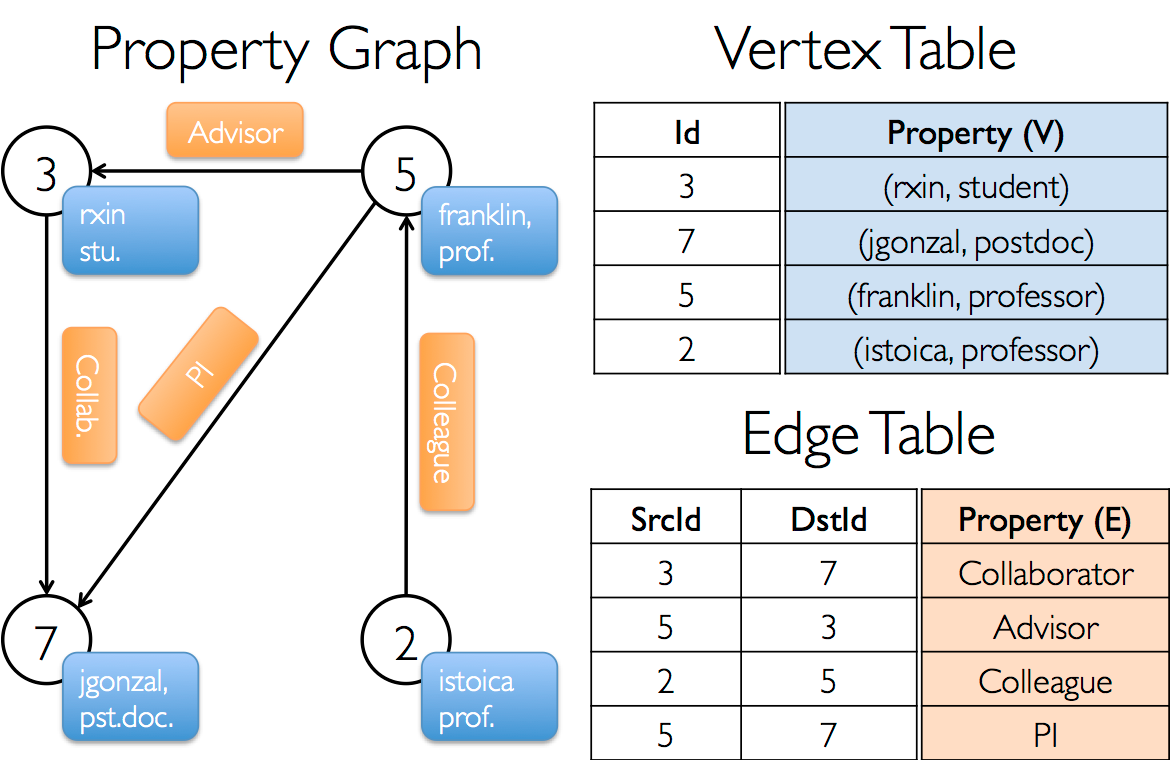

The resulting graph would have the type signature:

In [ ]:
val userGraph: Graph[(String, String), String]

There are numerous ways to construct a property graph from raw files, RDDs, etc., but probably the most general method is to use the `Graph` object. For example the following code constructs a graph from a collection of RDDs:

In [ ]:
// Assume the SparkContext has already been constructed

val spark = SparkSession
      .builder
      .appName(s"${this.getClass.getSimpleName}")
      .getOrCreate()
val sc = spark.sparkContext

// Create an RDD for the vertices
val users: RDD[(VertexId, (String, String))] =
  sc.parallelize(Array((3L, ("rxin", "student")), (7L, ("jgonzal", "postdoc")),
                       (5L, ("franklin", "prof")), (2L, ("istoica", "prof"))))
// Create an RDD for edges
val relationships: RDD[Edge[String]] =
  sc.parallelize(Array(Edge(3L, 7L, "collab"),    Edge(5L, 3L, "advisor"),
                       Edge(2L, 5L, "colleague"), Edge(5L, 7L, "pi")))
// Define a default user in case there are relationship with missing user
val defaultUser = ("John Doe", "Missing")
// Build the initial Graph
val graph = Graph(users, relationships, defaultUser)

In the above example we make use of the `Edge` case class. Edges have a `srcId` and a `dstId` corresponding to the source and destination vertex identifiers. In addition, the `Edge` class has an `attr` member which stores the edge property.

We can deconstruct a graph into the respective vertex and edge views by using the `graph.vertices` and `graph.edges` members respectively.

In [ ]:
graph.vertices.take(5).foreach(println)

In [ ]:
graph.edges.take(5).foreach(println)

Count all users which are *postdocs*:

In [ ]:
graph.vertices.filter { case (id, (name, pos)) => pos == "postdoc" }.count

Count all the edges where src > dst:

In [ ]:
graph.edges.filter(e => e.srcId > e.dstId).count

Note that `graph.vertices` returns an `VertexRDD[(String, String)]` which extends `RDD[(VertexId, (String, String))]`and so we use the scala `case` expression to deconstruct the tuple. On the other hand, `graph.edges` returns an EdgeRDD containing Edge[String] objects. We could have also used the case class type constructor as in the following:

In [ ]:
graph.edges.filter { case Edge(src, dst, prop) => src > dst }.count

Compute the in-degree of each vertex:

In [ ]:
graph.inDegrees.collect.foreach(println)

In addition to the vertex and edge views of the property graph, GraphX also exposes a triplet view. The triplet view logically joins the vertex and edge properties yielding an `RDD[EdgeTriplet[VD, ED]]` containing instances of the `EdgeTriplet` class.

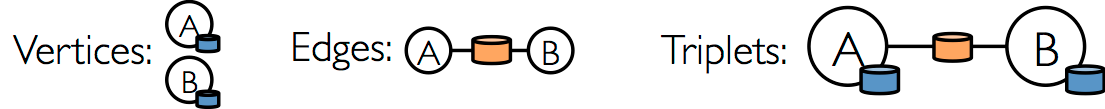

In [ ]:
val facts: RDD[String] = graph.triplets.map(triplet => triplet.srcAttr._1 + " is the " + triplet.attr + " of " + triplet.dstAttr._1)

facts.collect.foreach(println)